# CPVT Patients Demographics

- Clinical features
  - Heart structure abnormalities
  - Exercise induced PVT
  - Exercise induced syncope
  - Exercise induced sudden cardiac arrest
  - Abnormal ECG at rest
- Patient sex
- Inheritance pattern
- Family history of sudden cardiac death

In [1]:
from typing import Callable

import pandas as pd
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from dataclasses import dataclass

from analysis.database import get_config
from analysis.write_report import PdfSection

sns.set_style("ticks")

In [2]:
config = get_config()

# create dir for figures
figures_dir = Path(
    os.path.join("..", "figures", config.version_for_dir, "analysis_08"))

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

In [3]:
figure_3 = config.figure3

colors = config.figure_palette

In [4]:
df = pd.read_excel(
    f"../data/individual_all_data-{config.version}.xlsx",
    index_col=0,
)
df.head()

,individual_id,sex,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,NaN,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,NaN,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,female,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",NaN,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
2,3,male,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",NaN,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,female,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",NaN,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,male,5,Gender differences in the inheritance mode of ...,"Ohno, S.",NaN,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_cpvt = df[
    df["Catecholaminergic polymorphic ventricular tachycardia 1"] == 1
    ]
# use this for individual data to prevent duplicates
df_cpvt_individuals = df_cpvt.drop_duplicates(subset="individual_id")
num_cpvt_patients = f"Number of CPVT patients: {df_cpvt_individuals.shape[0]}"

In [6]:
# number of unique variants
print(df_cpvt["sequence_variant_id"].nunique())
# number of protein HGVS strings (should be less since cdna will sometimes map to same amino acid)
df_cpvt["p_hgvs_string"].nunique()

281


272

In [7]:
def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir / f"{name}.{fmt}"), dpi=300)


def add_bar_label(curr_ax: plt.Axes):
    for container in curr_ax.containers:
        curr_ax.bar_label(
            container,
            fmt="n=%g",
            fontsize=8,
        )


def remap_values(df_input: pd.DataFrame, column: str, mapping: dict, *,
                 num_total_samples: int, map_fn: Callable = None,
                 count_col: str = "count"):
    df_input[column] = df_input[column].apply(
        lambda x: mapping.get(map_fn(x), x) if map_fn else mapping.get(x, x)
    )
    df_input["percentage"] = df_input[count_col].apply(
        lambda x: x / num_total_samples * 100
    ).round(2)

    order_cats = list(mapping.values())
    palette = {
        x_axis: color for x_axis, color in
        zip(order_cats, sns.color_palette(colors.cat_palette, len(order_cats)))
    }

    return order_cats, palette


## Clinical features


In [8]:
df_cpvt_individuals["Heart Structure Abnormality"].value_counts()

Heart Structure Abnormality
0.0    447
1.0     44
Name: count, dtype: int64

In [9]:
from matplotlib.figure import Figure
from analysis.database import set_figure_size
import heapq


@dataclass
class AxesInfo:
    panel: str
    plot: Figure

    # define a sorting key for the heap (the panel name)
    def __lt__(self, other):
        if isinstance(other, AxesInfo):
            return self.panel < other.panel
        return NotImplemented


def add_or_update_heap(heap: list[AxesInfo], new_axes: AxesInfo):
    """
    Add or update the heap with the new axes. Keep it heap sorted by panel name
    """
    # I know this can slow since search in heap is O(n) but this
    # will be small
    for idx, axes in enumerate(heap):
        if axes.panel == new_axes.panel:
            heap[idx] = new_axes
            heapq.heapify(heap)
            return

    # add to the heap
    heapq.heappush(heap, new_axes)


@dataclass
class AxesPlotted:
    axes_plotted: list[AxesInfo]

    def __init__(self):
        self.axes_plotted = []

    def add_entry(self, panel: str, plot: Figure):
        add_or_update_heap(self.axes_plotted, AxesInfo(panel=panel, plot=plot))


axes_plotted = AxesPlotted()
condition_info: dict[str, PdfSection] = {}

In [10]:
def plot_counts_df(df_cat_inputs: pd.DataFrame,
                   column: str,
                   panel: str,
                   *,
                   map_fn: Callable = None,
                   section_title: str,
                   counting_title: str,
                   ):
    """
    Args:
        df_cat_inputs: Pandas dataframe with a column of categorical values or boolean values
        column: Column name to count
        panel: The name of the panel in figure 3 to use
        map_fn: Function to map the values to a different value
        section_title: Title of the section in the PDF
        counting_title: What is
    """

    # create the df with [colname, count]
    df_counted = pd.DataFrame(
        df_cat_inputs[column].value_counts()).reset_index()
    cat_list, count_pallette = remap_values(
        df_counted,
        column,
        figure_3.panels[panel].xticklabels,
        num_total_samples=df_counted["count"].sum(),
        map_fn=map_fn
    )

    condition_info[panel] = PdfSection(
        section=section_title,
        stuff=[
            f"Num total {counting_title} {df_counted['count'].sum()}",
            df_counted
        ]
    )

    curr_panel = figure_3.panels[panel]

    fig = plt.figure(figsize=figure_3.fig_size)

    sns.barplot(
        data=df_counted,
        x=column,
        y="count",
        hue=column,
        legend=False,
        edgecolor="black",
        palette=sns.color_palette(colors.cat_palette, len(cat_list)),
        order=cat_list,
        hue_order=cat_list,
        ax=fig.gca()
    )
    add_bar_label(fig.gca())
    set_figure_size(
        curr_panel
    )

    axes_plotted.add_entry(panel=panel, plot=fig)

    save_current_plot(f"figure_3_{panel}")

    plt.show()

## Family history of sudden cardiac death

In [11]:
bool(np.nan)

True

In [12]:
df_scd = df_cpvt_individuals[[
    "individual_id",
    "Sudden cardiac death::Mother",
    "Sudden cardiac death::Father",
    "Sudden cardiac death::num_family_members",
]].copy()
family_scd_col = "Family History of SCD"


def has_scd(row):
    if pd.isna(row["Sudden cardiac death::Mother"]) and pd.isna(
            row["Sudden cardiac death::Father"]) and pd.isna(
        row["Sudden cardiac death::num_family_members"]):
        return np.nan

    mother = row["Sudden cardiac death::Mother"] == 1
    father = row["Sudden cardiac death::Father"] == 1
    num_family_members = row["Sudden cardiac death::num_family_members"] > 0

    return mother or father or num_family_members


df_scd[family_scd_col] = df_scd.apply(
    has_scd,
    axis=1
)
df_scd.head()

,individual_id,Sudden cardiac death::Mother,Sudden cardiac death::Father,Sudden cardiac death::num_family_members,Family History of SCD
0,1,1.0,0.0,NaN,True
1,2,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN
3,4,NaN,NaN,0.0,False
4,5,NaN,NaN,NaN,NaN


# Plot all the plots

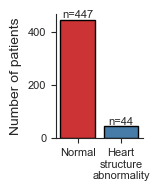

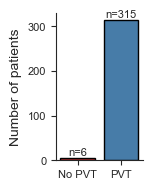

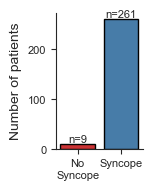

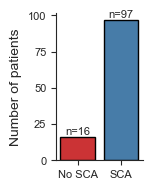

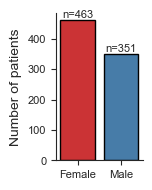

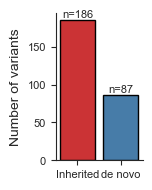

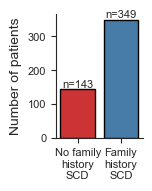

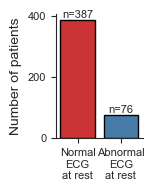

In [13]:
@dataclass
class Figure3Panel:
    column: str
    panel: str
    df_plt: pd.DataFrame
    section_title: str | None = None
    counting_title: str = "patients"


conditions_to_graph = [
    Figure3Panel(
        column="Heart Structure Abnormality",
        panel="panel_a",
        df_plt=df_cpvt_individuals,
    ),
    Figure3Panel(
        column="Exercise/stress induced polymorphic ventricular tachycardia",
        panel="panel_b",
        df_plt=df_cpvt_individuals,
    ),
    Figure3Panel(
        column="Syncope exercise/stress induced",
        panel="panel_c",
        df_plt=df_cpvt_individuals,
    ),
    Figure3Panel(
        column="Exercise/stress induced sudden cardiac arrest",
        panel="panel_d",
        df_plt=df_cpvt_individuals,
    ),
    Figure3Panel(
        column="sex",
        panel="panel_e",
        df_plt=df_cpvt_individuals,
        section_title="Patient Sex"
    ),
    Figure3Panel(
        df_plt=df_cpvt,
        column="inheritance",
        panel="panel_f",
        counting_title="variants",
        section_title="Inheritance"
    ),
    Figure3Panel(
        column=family_scd_col,
        panel="panel_g",
        df_plt=df_scd,
        section_title="Family History of SCD",
    ),
    Figure3Panel(
        column="Baseline/resting electrocardiogram abnormality",
        panel="panel_h",
        df_plt=df_cpvt_individuals,
    ),
]

for fig_info in conditions_to_graph:
    plot_counts_df(
        fig_info.df_plt,
        fig_info.column,
        fig_info.panel,
        section_title=fig_info.section_title if fig_info.section_title else fig_info.column,
        counting_title=fig_info.counting_title
    )



In [14]:
axes_plotted

AxesPlotted(axes_plotted=[AxesInfo(panel='panel_a', plot=<Figure size 162.5x200 with 1 Axes>), AxesInfo(panel='panel_b', plot=<Figure size 162.5x200 with 1 Axes>), AxesInfo(panel='panel_c', plot=<Figure size 162.5x200 with 1 Axes>), AxesInfo(panel='panel_d', plot=<Figure size 162.5x200 with 1 Axes>), AxesInfo(panel='panel_e', plot=<Figure size 162.5x200 with 1 Axes>), AxesInfo(panel='panel_f', plot=<Figure size 162.5x200 with 1 Axes>), AxesInfo(panel='panel_g', plot=<Figure size 162.5x200 with 1 Axes>), AxesInfo(panel='panel_h', plot=<Figure size 162.5x200 with 1 Axes>)])

## Write information to PDF

In [39]:
from analysis.write_report import write_sections_to_pdf
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

# report
pdf_name = figures_dir / "cpvt_demographics.pdf"

# Create PDF and write content
c = canvas.Canvas(str(pdf_name), pagesize=A4)
write_sections_to_pdf(c, list(condition_info.values()))
c.save()

print(f"PDF saved to {pdf_name}")

PDF saved to ../figures/0_3_1/analysis_08/cpvt_demographics.pdf


## Create a 2x4 grid of the plots

In [ ]:
# Create a figure with GridSpec for precise layout
from matplotlib.gridspec import GridSpec